In [1]:
from pybedtools import BedTool
import csv
from collections import defaultdict
from collections import Counter
from glob import glob
import numpy as np

In [2]:
import seaborn as sns
import pandas as pd

In [3]:
import pyBigWig

In [4]:
tips = sns.load_dataset("tips")


In [5]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [6]:
peakList=glob("*.npk")

In [7]:
print(peakList)


['Prism_all.npk', '16-cells_all.npk', 'EarlyBlastula_all.npk', 'Pluteus_all.npk', 'Gastrula_all.npk', 'LateBlastula_all.npk']


In [8]:
peakDict={pk.split('.')[0]:BedTool(pk) for pk in peakList}

In [9]:
peakLength={stg:[p.length for p in peakDict[stg]] for stg in peakDict}
    

In [10]:
pklen,pksum=[[],[]],[]
for stg in peakLength:
    print(stg,sum(peakLength[stg]),round(np.mean(peakLength[stg]),2))
    for p in peakLength[stg]:
        pklen[0].append(stg)
        pklen[1].append(p)

Prism_all 55986874 501.73
16-cells_all 18184373 602.23
EarlyBlastula_all 72500186 508.88
Pluteus_all 23951798 538.84
Gastrula_all 74756124 485.95
LateBlastula_all 63156427 476.4


In [11]:
pkL= pd.Series(pklen,index=['stg','len'])

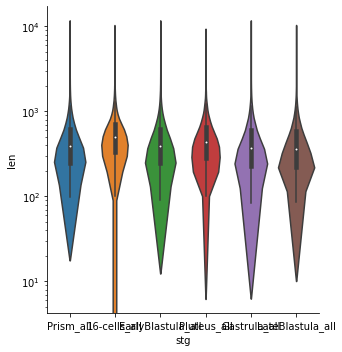

In [12]:
g=sns.catplot(x="stg", y="len", data=pkL,kind="violin")
g.set(yscale="log")


In [13]:
g.savefig('peak_size.pdf')


In [14]:
peakBeds=[BedTool(pk) for pk in peakList]

In [15]:

peakBeds[0][0].length

359

In [16]:
mrg=peakBeds[0].cat(*peakBeds[1:]).saveas('merged.bed')

In [17]:
print(len(mrg))

185294


In [18]:
mrgList=[(elt[0],int(elt[1]),int(elt[2]),"peak_{0}".format(i)) for i,elt in enumerate(csv.reader(open('merged.bed'),delimiter='\t'))]

In [19]:
mrgNm=BedTool(mrgList)

In [20]:
mrgNm.head()

Scaffold_10	7	274	peak_0
 Scaffold_1001	663	1059	peak_1
 Scaffold_1002	4115	4407	peak_2
 Scaffold_1003	1027	2809	peak_3
 Scaffold_1003	2991	3498	peak_4
 Scaffold_1003	6948	7494	peak_5
 Scaffold_1003	7919	8522	peak_6
 Scaffold_1003	8646	8823	peak_7
 Scaffold_1004	5144	5295	peak_8
 Scaffold_1005	21	1837	peak_9
 

## Intersection with repeats

In [21]:
repeats=BedTool("Pliv_PqN3S.rep.bed")

In [22]:
repeats.head()

Scaffold_1	1351	1411	Simple_repeat
 Scaffold_1	1561	1589	Simple_repeat
 Scaffold_1	1996	2106	Simple_repeat
 Scaffold_1	3292	3363	Simple_repeat
 Scaffold_1	3647	3675	Simple_repeat
 Scaffold_1	4178	4266	Simple_repeat
 Scaffold_1	4468	4557	Simple_repeat
 Scaffold_1	4915	5095	Simple_repeat
 Scaffold_10	3	13	Unknown
 Scaffold_10	14	254	DNA
 

In [23]:
#mrgRep=mrgNm.intersect(repeats,wa=True,wb=True,f=0.2)


In [24]:
mrgNm.head()

Scaffold_10	7	274	peak_0
 Scaffold_1001	663	1059	peak_1
 Scaffold_1002	4115	4407	peak_2
 Scaffold_1003	1027	2809	peak_3
 Scaffold_1003	2991	3498	peak_4
 Scaffold_1003	6948	7494	peak_5
 Scaffold_1003	7919	8522	peak_6
 Scaffold_1003	8646	8823	peak_7
 Scaffold_1004	5144	5295	peak_8
 Scaffold_1005	21	1837	peak_9
 

In [25]:
mrgRep=mrgNm.intersect(repeats,u=True,f=0.3)

In [26]:
repSet=set([p.fields[3] for p in mrgRep])

In [27]:
print(len(repSet))

104486


In [28]:
mrgRepIsct=mrgNm.intersect(repeats).saveas('mergedRepIsct.bed')

In [29]:
n=0

for i,elt in enumerate(csv.reader(open('mergedRepIsct.bed'),delimiter='\t')):
    scaf,start,end,name=elt[0],int(elt[1]),int(elt[2]),elt[3]
    size=abs(end-start)
    #,"peak_{0}".format(i)) 
    #print (scaf,start,end,abs(end-start),name)
    if size>100:
        n+=1
    #if i==30: break
print(i,n)


257939 144584


## Intersection with conserved elements

In [ ]:
Echinoidea.mcons.bed

In [22]:
print(len(mrgNm))

185294


In [50]:
mostCons=BedTool("echino2.mostcons.bed")

In [56]:
print(len(mostCons))

112801


In [57]:
mrgCons=mrgNm.intersect(mostCons,wa=True,wb=True)

In [58]:
consSet=set([p.fields[3] for p in mrgCons])

In [59]:
print(len(consSet))

19689


In [49]:
print(len(consSet))

14694


## Position toward genes

In [41]:
from pybedtools.featurefuncs import TSS

In [42]:
genes=BedTool("/Users/fmarletaz/Dropbox/Genomes/Urchin/ATAC-urchin/Ressources/Pliv_aH2p.filt.bed")

In [43]:
gene_tss = genes.each(TSS, upstream=0, downstream=1).sort().saveas('Pliv_aH2p.tss.bed')

In [44]:
#tssDict={p.fields[3]:p.fields[7].split('.')[0] for p in mrgTss}

In [45]:
gene_tss.head()

Scaffold_10	844	845	PL30914.1	1000	-	733	845	0	1	112,	0,
 Scaffold_1003	7950	7951	PL04642.1	1000	+	7950	8803	0	3	153,173,100,	0,440,753,
 Scaffold_1005	12110	12111	PL33535.1	1000	+	12110	13719	0	3	33,53,127,	0,864,1482,
 Scaffold_1006	30416	30417	PL41561.1	1000	+	30940	31243	0	1	1096,	0,
 Scaffold_1006	31516	31517	PL41563.1	1000	+	31516	31987	0	1	471,	0,
 Scaffold_1006	50816	50817	PL41562.1	1000	+	50816	52221	0	2	191,253,	0,1152,
 Scaffold_1012	66615	66616	PL41465.1	1000	-	65944	66616	0	1	672,	0,
 Scaffold_1012	169278	169279	PL41476.1	1000	-	156423	169279	0	3	210,118,11,	0,10359,12845,
 Scaffold_1012	176694	176695	PL41474.1	1000	-	174547	176695	0	2	653,1237,	0,911,
 Scaffold_1016	10756	10757	PL00006.1	1000	+	10756	12195	0	2	94,54,	0,1385,
 

In [50]:
mrgClose=mrgNm.closest(gene_tss,D='a').saveas('closest_tss.bed')

In [51]:
gl={g.name.split('.')[0]:abs(int(g.end)-g.start) for g in genes}

In [52]:
#mrgClose=mrgNm.closest(genes,D='a').saveas('closest.bed')

In [53]:
geneDist={p[3]:(p.fields[7].split('.')[0],int(p[-1])) for p in mrgClose}

In [54]:
genStatus={}
ct=0
for pk,df in geneDist.items():
    gene,d=df
    if gene=='': 
        genStatus[pk]='distal'
    else:
        if d>-500 and d<1000:
            genStatus[pk]='tss'
        elif d<0 and abs(d)<gl[gene]:
            genStatus[pk]='genebody'
        elif d>0 and d<5000:
            genStatus[pk]='proximal'
        else: 
            genStatus[pk]='distal'
    #print(pk,gene,d,genStatus[pk])

In [55]:
#print(list(geneDist.items())[0:3])
print(genStatus['peak_153'])

distal


In [56]:
print(Counter(genStatus.values()))

Counter({'distal': 95636, 'genebody': 45969, 'tss': 22208, 'proximal': 21481})


 ## Intersection matrix 

In [57]:
mrgNm.intersect(peakBeds[0],u=True,f=0.25).head()

Scaffold_1003	1027	2809	peak_3
 Scaffold_1003	2991	3498	peak_4
 Scaffold_1003	6948	7494	peak_5
 Scaffold_1005	21	1837	peak_9
 Scaffold_1005	5075	5827	peak_10
 Scaffold_1006	2159	2771	peak_12
 Scaffold_1006	18241	19034	peak_15
 Scaffold_1006	25612	26019	peak_17
 Scaffold_1006	27285	27555	peak_18
 Scaffold_1006	28378	28782	peak_19
 

In [58]:
IntrSc={}
for cond in peakList:
    cdn=cond.split('_')[0]
    pkBed=BedTool(cond)
    tmpInt=mrgNm.intersect(pkBed,u=True,f=0.1)
    IntrSc[cdn]=set([p.fields[3] for p in tmpInt])
    print(cdn,len(IntrSc[cdn]))

Prism 104089
16-cells 27501
EarlyBlastula 137938
Pluteus 39623
Gastrula 147188
LateBlastula 124419


## Master table


In [59]:
from statistics import mean
import pandas as pd

In [60]:
tab=[(p.name,p.chrom,p.start,p.end,abs(p.end-p.start)) for p in mrgNm]

In [61]:
print(tab[0:3])

[('peak_0', 'Scaffold_10', 7, 274, 267), ('peak_1', 'Scaffold_1001', 663, 1059, 396), ('peak_2', 'Scaffold_1002', 4115, 4407, 292)]


In [62]:
peakMaster = pd.DataFrame(tab, columns =['Peak', 'Scaf','Start','End','Size']) 

In [63]:
peakMaster=peakMaster.set_index('Peak')

In [65]:
repDict={p.name:(1 if p.name in repSet else 0) for p in mrgNm}

In [66]:
consDict={p.name:(1 if p.name in consSet else 0)  for p in mrgNm if p.name}

In [67]:
pgn={e[0]:e[1] for e in csv.reader(open('../../Annotation/Pliv_genes_master_filt.txt'),delimiter='\t')}

In [68]:
genDict={p:x[0] for p,x in geneDist.items()}

In [69]:
distDict={p:x[1] for p,x in geneDist.items() if not x[1]==-1}

In [70]:
peakMaster["Repeat"] = pd.Series(repDict)

In [71]:
peakMaster["Cons"] = pd.Series(consDict)

In [72]:
peakMaster["Status"]=pd.Series(genStatus)

In [73]:
peakMaster["Closest"]=pd.Series(genDict)

In [74]:
genNmn={p:pgn.get(g,'') for p,g in genDict.items()}

In [75]:
peakMaster["ClosestN"]=pd.Series(genNmn)

In [76]:
peakMaster["Dist"]=pd.Series(distDict)

In [77]:
ordStg=['16-cells','EarlyBlastula',  'LateBlastula', 'Gastrula', 'Prism', 'Pluteus']

In [78]:
patDict=defaultdict(str)

In [79]:
for cond in ordStg:
    conDict={p.name:(1 if p.name in IntrSc[cond] else 0) for p in mrgNm}
    for p in mrgNm:
        BN='Y' if conDict[p.name]==1 else 'N'
        patDict[p.name]+=str(BN)
    peakMaster[cond]=pd.Series(conDict, dtype='category')

In [80]:
print(Counter(patDict.values()))

Counter({'NYYYYN': 37041, 'NYNNNN': 25505, 'YYYYYY': 16867, 'NYYYYY': 16389, 'NYYYNN': 15727, 'NNNYNN': 13526, 'YYYYYN': 9158, 'NYNYNN': 8877, 'NNYYYN': 8127, 'NNNYYN': 6467, 'NNYYNN': 6425, 'NNYNNN': 4814, 'NYYNNN': 4735, 'NNYYYY': 3856, 'NNNYYY': 1830, 'NYNYYN': 1729, 'NNNNYN': 1691, 'YYYYNN': 897, 'NNNNYY': 358, 'YYNNNN': 276, 'NYNNYN': 189, 'YYYNNN': 169, 'NNNNNY': 136, 'NYNYYY': 123, 'NYYNYN': 94, 'NNYNYN': 90, 'YYNYNN': 80, 'YYNYYN': 39, 'NNNYNY': 16, 'NYNNYY': 16, 'YYNNYN': 9, 'NNYNYY': 9, 'NNYYNY': 8, 'NYYYNY': 5, 'NYNNNY': 5, 'YYYNYN': 4, 'NYYNYY': 3, 'YNNNNN': 2, 'NYNYNY': 1, 'NNYNNY': 1})


In [81]:
peakMaster['Pattern'] = pd.Series(patDict)

In [88]:
#peakMaster['Motif'] = pd.Series(pkTFs)
peakMaster['TF'] = pd.Series(pk_tf)

In [98]:
peakMaster[(peakMaster.Repeat==0) & (peakMaster.Status != 'tss') ]

,Scaf,Start,End,Size,Repeat,Cons,Status,Closest,ClosestN,Dist,16-cells,EarlyBlastula,LateBlastula,Gastrula,Prism,Pluteus,Pattern,TF
Peak,,,,,,,,,,,,,,,,,,
peak_2,Scaffold_1002,4115,4407,292,0,0,distal,,,NaN,0,1,0,1,0,0,NYNYNN,"thr,atf4l,hnf6,casp,alx3,oct1-2,fxr,nurr1,rxr-..."
peak_7,Scaffold_1003,8646,8823,177,0,0,genebody,PL04642,unchar-7019,-696.0,0,1,0,0,0,0,NYNNNN,"z114,hmbox1,unchar-11716,gcm,irf4"
peak_18,Scaffold_1006,27285,27555,270,0,0,proximal,PL41561,unchar-21852,2862.0,0,1,1,1,1,0,NYYYYN,"pu1,hmb4,erg,hnf4,hlf-1,smad_ip,erf,six3,cebpg..."
peak_29,Scaffold_101,1945,2432,487,0,0,distal,,,NaN,0,1,0,0,0,0,NYNNNN,"z155,soxb2,mef2c,neurod1,sox6l,myor2,unchar-11..."
peak_55,Scaffold_1012,118456,118679,223,0,0,distal,PL41476,unchar-1347,50600.0,0,1,0,0,0,0,NYNNNN,"nfic,klf15,myb,ap2,srf,hmbox1,sox6l,z326,elfa,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak_185277,Scaffold_994,13860,14820,960,0,0,distal,,,NaN,1,1,1,1,1,0,YYYYYN,"z155,rxr-1,z326,cdx,klf13,hmb4,gabp,unchar-103..."
peak_185278,Scaffold_994,14959,15062,103,0,0,distal,,,NaN,0,1,0,0,0,0,NYNNNN,"pu1,soxe"
peak_185279,Scaffold_994,15905,16248,343,0,0,distal,,,NaN,1,1,1,1,1,0,YYYYYN,"soxb2,z326,srebp,tbx3,pax6,myb,ctl,sox6l,mbx1,..."


In [99]:
25097/64701

0.3878919954869322

In [90]:
reOrdCol=['Scaf', 'Start', 'End', 'Size', 'Repeat', 'Cons', 'Status', 'Closest','ClosestN' ,'Dist','16-cells', 'EarlyBlastula',  'LateBlastula', 'Gastrula', 'Prism', 'Pluteus','Pattern','TF']


In [91]:
peakMaster=peakMaster[reOrdCol]

In [92]:
len(peakMaster[(peakMaster['Repeat']==0)])

80808

In [71]:
peakMaster[(peakMaster['Repeat']==0)].to_csv('stage_peaks.txt',sep='\t')

In [77]:
peakMaster[(peakMaster['Repeat']==0)].reset_index()[['Scaf','Start','End','Peak']].to_csv('stage_peaks.bed',sep='\t',header=False,index=False)


In [72]:
peakMaster_Enh=peakMaster[(peakMaster['Repeat']==0)&(peakMaster['Status']!='tss')]

In [73]:
peakMaster_Prom=peakMaster[(peakMaster['Repeat']==0)&(peakMaster['Status']=='tss')]

In [74]:
peakMaster_Enh.reset_index()[['Scaf','Start','End','Peak']].to_csv('stage_peak_enh.bed',sep='\t',header=False,index=False)
#peakMaster_Prom.to_csv('stage_peak_tss.txt',sep='\t',header=False)

In [75]:
peakMaster_Prom.reset_index()[['Scaf','Start','End','Peak']].to_csv('stage_peak_tss.bed',sep='\t',header=False,index=False)



In [76]:
Counter(peakMaster_Enh['Pattern'])

Counter({'NYNYNN': 1633,
         'NYNNNN': 6320,
         'NYYYYN': 9119,
         'NYYYNN': 3057,
         'NNNYNN': 7146,
         'NNYYYN': 4835,
         'NYYYYY': 7285,
         'YYYYYY': 5034,
         'NNNYYN': 4819,
         'NNYYNN': 2797,
         'NNNNYN': 1247,
         'YYYYYN': 1907,
         'NYYNNN': 1310,
         'NYNYYN': 612,
         'NNYNNN': 1973,
         'NNYYYY': 2911,
         'NNNYYY': 1507,
         'NNYNYN': 51,
         'NYNNYN': 86,
         'YYNNNN': 135,
         'NYYNYN': 30,
         'YYYYNN': 254,
         'NNNNYY': 286,
         'NYYYNY': 3,
         'YYYNNN': 72,
         'NNNNNY': 114,
         'YYNYYN': 10,
         'NYNYNY': 1,
         'NYNYYY': 71,
         'YYNNYN': 5,
         'YYNYNN': 29,
         'NNNYNY': 15,
         'NNYNYY': 6,
         'NNYYNY': 8,
         'NYNNYY': 6,
         'YYYNYN': 4,
         'NYNNNY': 2,
         'NNYNNY': 1})

In [322]:
print(len(peakMaster_Prom),len(peakMaster_Enh))

15858 62616


In [65]:
peakMaster

,Scaf,Start,End,Size,Repeat,Cons,Status,Closest,Dist,16-cells,EarlyBlastula,LateBlastula,Gastrula,Prism,Pluteus,Pattern,TF
Peak,,,,,,,,,,,,,,,,,
peak_0,Scaffold_10,7,274,267,1,0,tss,PL30914,571.0,0,1,1,1,0,0,NYYYNN,NaN
peak_1,Scaffold_1001,663,1059,396,1,0,distal,,NaN,0,1,0,0,0,0,NYNNNN,NaN
peak_2,Scaffold_1002,4115,4407,292,0,0,distal,,NaN,0,1,0,1,0,0,NYNYNN,"thr,atf4l,hnf6,casp,alx3,oct1-2,fxr,nurr1,rxr-..."
peak_3,Scaffold_1003,1027,2809,1782,1,0,distal,PL04642,5142.0,1,1,1,1,1,1,YYYYYY,NaN
peak_4,Scaffold_1003,2991,3498,507,1,0,proximal,PL04642,4453.0,0,1,1,1,1,0,NYYYYN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak_185289,Scaffold_996,723,1104,381,0,0,genebody,PL25239,-723.0,0,0,1,0,0,0,NNYNNN,NaN
peak_185290,Scaffold_996,4341,4933,592,0,0,proximal,PL25240,1503.0,0,1,1,1,1,0,NYYYYN,NaN
peak_185291,Scaffold_996,5043,5526,483,0,0,tss,PL25240,910.0,0,0,1,1,0,0,NNYYNN,NaN


In [147]:
peakMaster.reset_index()[['Scaf','Start','End','Peak']]

,Scaf,Start,End,Size,Repeat,Cons,Status,Closest,Dist,16-cells,EarlyBlastula,LateBlastula,Gastrula,Prism,Pluteus,Pattern
Peak,,,,,,,,,,,,,,,,
peak_0,Scaffold_10,7,279,272,1,0,tss,PL30914,566.0,0,1,1,0,0,0,NYYNNN
peak_1,Scaffold_1002,4118,4407,289,0,0,distal,,NaN,0,1,1,1,0,0,NYYYNN
peak_2,Scaffold_1003,1028,2793,1765,0,0,distal,PL04642,5158.0,1,1,1,1,1,1,YYYYYY
peak_3,Scaffold_1003,2991,3498,507,0,0,proximal,PL04642,4453.0,0,1,1,1,1,0,NYYYYN
peak_4,Scaffold_1003,6958,7356,398,0,0,tss,PL04642,595.0,0,1,1,1,1,0,NYYYYN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak_181290,Scaffold_994,32968,33153,185,0,0,distal,,NaN,0,1,1,0,0,0,NYYNNN
peak_181291,Scaffold_994,33263,33897,634,1,0,distal,,NaN,1,1,1,1,1,1,YYYYYY
peak_181292,Scaffold_996,4449,4933,484,0,0,proximal,PL25240,1503.0,0,1,1,1,1,0,NYYYYN


In [105]:
for pk in peakMaster.head().itertuples():
    print(pk.Index, pk.Start, pk.End)

peak_0 7 279
peak_1 4118 4407
peak_2 1028 2793
peak_3 2991 3498
peak_4 6958 7356


In [ ]:
peakMaster.to_csv('stage_peaks.txt',sep='\t')

In [85]:
patSet=set([p for p,n in Counter(patDict.values()).items() if n > 100])

In [55]:
patSet

{'NNNNNY',
 'NNNNYN',
 'NNNNYY',
 'NNNYNN',
 'NNNYYN',
 'NNNYYY',
 'NYYNNN',
 'NYYYNN',
 'NYYYYN',
 'NYYYYY',
 'YYYNNN',
 'YYYYNN',
 'YYYYYN',
 'YYYYYY'}

In [190]:
print(Counter(repDict.values()))

Counter({1: 102821, 0: 78474})


### Footprinting

In [83]:
pk_tf={l[0]:l[1] for l in csv.reader(open('pk_bd_tf_an.tsv'),delimiter='\t')}

In [84]:
print(list(pk_tf.items())[0])

('peak_108', 'z155,rel-1,ftzf,hey,rxr-1,z145,thap4-3,vdra,z218,rxr-2,pax6,z147,hnf6,neurod1,jun,plag1,tgif,xfin-4,mox,hxa10,z114,evi1,anln,oct1-2,irf4,ari5b,klf7,egr,tll,pax9,nfe2,hen1,clock,fxr,gcnf1,z103,glia,ptf1a,lhx3,soxb2,srf,nfil3,mad-2,srebp,cdx,hmb4,gabp,hox11,rfx5,smad4,sp2,klf15,pold,cp2,sox6l,sna,hlf-1,blimp1,creb1,cr3l3,stat,atf4l,runt1,usp10,foxc,eltd1,sia4b,lin54ll,e2f7,tead1,e2f3,scl,pou4f2,myod,alx3,elfa,sp8,cebpa,mlxpl,ppar1,z434,foxd,unchar-5802,klf13,unchar-10300,tbx20-2,shr2,ndufb9,nfya,lmx1b,tlx3,xbp1,irf,ap2,yyi,z181,ctl,pknox,tbr,z276,rreb1-1,tbx2b,otx-2,six3,soxf,osr,mafs,fra2,ntl,ehf,gatac,tssk4,soxb1,hmx,usf,hsf,mlx-1,unchar-11716,nfyc,alx1,nr1h6,mist,err,ctcf,p3a2,unchar-19815,z223,pu1,z326,tbx3,smarca3,scratch,hxbaa,glisb,xfin-2,unchar-4546,twi,unchar-15935,mef2c,hnf4,myor2,smad_ip,fos-2,gatal,dr-1,z367,nurr1,z480,unchar-16975,hand2,soxe,klf3,soxc,barh1,e12,tf7l2,fuk-1,maf,hxb9,rfx2,nfat,thr,bhe23,ngn,nkx3,rar,nk2,six1,tcfap4l,pbx1,suh-2,smad1')


In [85]:
pk_an={l[0]:l[4] for l in csv.reader(open('bindetect_results_anf.txt'),delimiter='\t')}

In [86]:
pk_tff={l:['{}_{}'.format(e,pk_an[e]) for e in t if e in pk_an] for l,t in pk_tf.items()}

In [87]:
print(list(pk_tff.items())[0])

('peak_108', [])


### Motifs

In [12]:
peaks=pd.read_csv('stage_peaks_anc.tsv',sep='\t')  

In [15]:
patDict=pd.Series(peaks.Pattern.values,index=peaks.Peak).to_dict()

In [75]:
with open('stage_4mael.txt','w') as out:
    for i, r in peaks[(peaks['Status']!='tss')].iterrows():
        out.write("{}:{}-{}\t{}\n".format(r['Scaf'], r['Start'], r['End'],r['Pattern']))

In [70]:
peaks[(peaks['Status']!='tss')]

,Peak,Scaf,Start,End,Size,Repeat,Cons,Status,Closest,ClosestN,...,16-cells,EarlyBlastula,LateBlastula,Gastrula,Prism,Pluteus,Pattern,Motif,Motif_TF,cons
0,peak_1,Scaffold_1002,4118,4407,289,0,0,distal,NaN,NaN,...,0,1,1,1,0,0,NYYYNN,"Nuclear_receptor.0005,Homeodomain.0029,Homeodo...","FXR,Gata2,LHX6,ZNF528,DUX4,ZNF274,CUX1,NFAT5,I...",0.000000
2,peak_6,Scaffold_1003,8646,8823,177,0,0,genebody,PL04642,unchar-7019,...,0,1,1,0,0,0,NYYNNN,"C2H2_ZF.0109,C2H2_ZF.0236,C2H2_ZF.0264","Ovol1,REST,Ovol1",0.277508
3,peak_15,Scaffold_1006,27294,27555,261,0,0,proximal,PL41561,unchar-21852,...,0,1,1,1,1,0,NYYYYN,"C2H2_ZF.0026,bZIP.0039,bZIP.0043,Mixed.0048,Nu...","ATF3,CEBPB,HLF,SIX5,HNF4G,ETS1,STAT3,PKNOX1,Tc...",0.137238
6,peak_27,Scaffold_101,1945,2432,487,0,0,distal,NaN,NaN,...,0,1,1,0,0,0,NYYNNN,"bHLH.0007,bHLH.0010,Sox.0006,bHLH.0023,bHLH.00...","Atoh1,Olig2,SOX14,CLOCK,HEY1,HES5,BHLHA15,FOXA...",0.000000
7,peak_53,Scaffold_1012,118456,118679,223,0,0,distal,PL41476,unchar-1347,...,0,1,1,0,0,0,NYYNNN,"Sox.0018,C2H2_ZF.0092,Sox.0024,Mixed.0044,Sox....","SOX10,HIC1,SOX10,BDP1,SOX21,MAF,MEF2A,ZBTB12,F...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78468,peak_181272,Scaffold_993,4133,5332,1199,0,0,distal,PL41462,NaN,...,1,1,1,1,1,1,YYYYYY,"Homeodomain.0003,MADS_box.0002,bZIP.0011,Myb_S...","HOXB7,AC002126.6,CEBPE,Mybl2,SOX9,Mef2a,KLF9,N...",0.000000
78469,peak_181278,Scaffold_994,13372,13592,220,0,0,distal,NaN,NaN,...,0,1,1,1,1,0,NYYYYN,"C2H2_ZF.0044,Nuclear_receptor.0051,IRF.0008,Mi...","IKZF1,NR2F2,Irf3,FLI1,CUX1,CUX1,PPARG",0.000000
78470,peak_181279,Scaffold_994,13860,14819,959,0,0,distal,NaN,NaN,...,1,1,1,1,1,0,YYYYYN,"Ets.0002,Homeodomain.0010,bHLH.0010,Sox.0007,D...","ELF5,Rhox8,Olig2,SOX9,DMRT1,Myf5,JUND,IKZF1,MY...",0.031510
78471,peak_181280,Scaffold_994,14959,15062,103,0,0,distal,NaN,NaN,...,0,1,1,0,0,0,NYYNNN,NaN,NaN,0.000000


In [49]:
pkTF['peak_3443']

['Homeodomain.0003',
 'Paired_box.0001',
 'Homeodomain_Paired_box.0001',
 'Homeodomain.0017',
 'Homeodomain.0027',
 'Homeodomain_Paired_box.0002',
 'Paired_box.0003',
 'Homeodomain.0085',
 'Homeodomain.0089',
 'Homeodomain.0096',
 'Paired_box.0004',
 'Paired_box.0009',
 'Homeodomain.0135',
 'Paired_box.0014',
 'GATA.0018',
 'Mixed.0076',
 'Homeodomain.0160',
 'Unknown.0122',
 'Mixed.0083',
 'C2H2_ZF.0219',
 'SAND.0008',
 'Forkhead.0057']

In [56]:
patSet

{'NNNNNY',
 'NNNNYN',
 'NNNNYY',
 'NNNYNN',
 'NNNYYN',
 'NNNYYY',
 'NYYNNN',
 'NYYYNN',
 'NYYYYN',
 'NYYYYY',
 'YYYNNN',
 'YYYYNN',
 'YYYYYN',
 'YYYYYY'}

In [54]:
patSet=set(['NYYYNN', 'YYYYNN', 'NYYNNN', 'NYYYYN', 'YYYYYY', 'YYYYYN', 'NNNYYN', 'NYYYYY', 'NNNYNN', 'NNNNYN',  'NNNYYY', 'YYYNNN', 'NNNNYY', 'NNNNNY'])

In [7]:
pkTF=defaultdict(list)
pkTFs,pkTGs={},{}
for elts in csv.reader(open('pk_tf.txt'),delimiter='\t'):
    pkTF[elts[0]]=elts[1].split(',')   
    pkTFs[elts[0]]=elts[1]
    pkTGs[elts[0]]=elts[2]

In [76]:
print(list(pkTGs.keys())[0:5])

['peak_1', 'peak_6', 'peak_15', 'peak_27', 'peak_53']


In [18]:
pkByTf=defaultdict(list)
for pk in pkTF:
    if pk in patDict:
        pat=patDict[pk]
        for fm in pkTF[pk]:
            pkByTf[fm].append(pk)

In [80]:
ctByTf={}
for m,p in pkByTf.items():
    ctByTf[m]=len(p)

In [ ]:
sorted(ctByTf.items(),key=lambda x:x[1],reverse=True)

In [50]:
patTF = {}
for tf,pks in pkByTf.items():
    pkpat=defaultdict(int)
    for pat in patSet:
        for pk in pks:
            if patDict[pk]==pat:
                pkpat[pat]+=1
    patTF[tf]=pkpat

In [51]:
matPatTF=pd.DataFrame.from_dict(patTF, orient='index').fillna(0)

In [64]:
matPatTF[(matPatTF['NNNNNY']!=0)]

,NYYYNN,YYYYNN,NYYNNN,NYYYYN,YYYYYY,YYYYYN,NNNYYN,NYYYYY,NNNYNN,NNNNYN,NNNYYY,YYYNNN,NNNNYY,NNNNNY
Nuclear_receptor.0005,80.0,12.0,149.0,218.0,215.0,64.0,215.0,290.0,169.0,27.0,172.0,8.0,7.0,3.0
Homeodomain.0029,115.0,4.0,138.0,279.0,321.0,79.0,210.0,403.0,134.0,42.0,187.0,2.0,19.0,4.0
C2H2_ZF.0080,61.0,6.0,94.0,170.0,220.0,40.0,122.0,223.0,96.0,14.0,90.0,2.0,4.0,2.0
C2H2_ZF.0118,84.0,12.0,148.0,206.0,304.0,58.0,174.0,273.0,134.0,14.0,150.0,3.0,1.0,2.0
CUT_Homeodomain.0005,69.0,2.0,63.0,154.0,227.0,47.0,137.0,337.0,90.0,37.0,202.0,4.0,22.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nuclear_receptor.0050,7.0,2.0,11.0,13.0,18.0,4.0,6.0,12.0,12.0,2.0,11.0,3.0,0.0,1.0
Runt.0002,10.0,3.0,23.0,43.0,33.0,8.0,28.0,51.0,20.0,3.0,16.0,1.0,0.0,1.0
bHLH.0093,11.0,0.0,12.0,15.0,21.0,4.0,12.0,22.0,11.0,1.0,3.0,0.0,1.0,1.0
Nuclear_receptor.0139,6.0,1.0,21.0,23.0,22.0,10.0,15.0,27.0,16.0,2.0,8.0,2.0,0.0,1.0


In [57]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

In [58]:
matPatTF.to_csv('mat_tf_pattern.txt',sep='\t')

In [59]:
nbtf=matPatTF.to_numpy().sum()

In [33]:
print(nbtf,matPatTF.sum(axis=1)[0],matPatTF.sum(axis=0)[0])

1585760.0 1629.0 92152.0


In [34]:
hypergeom.sf(3,nbtf,matPatTF.sum(axis=1)[0],matPatTF.sum(axis=0)[0])

1.0

In [228]:
hypergeom(218,sum(matPatTF.iloc[0]),sum(matPatTF.iloc[:,0]))

In [252]:
matPatTF.iloc[0, matPatTF.columns.get_loc('NYYYYN')]

218.0

In [60]:
pvalPat=pd.DataFrame(index=matPatTF.index)

In [38]:
for i,(pat,vals) in enumerate(matPatTF.items()):
    print(pat)
    pvals=[]
    for j,v in enumerate(vals):
        phyp=hypergeom.sf(v,nbtf,matPatTF.sum(axis=1)[0],matPatTF.sum(axis=0)[0])
        pvals.append(phyp)
        #print(i,j,v,matPatTF.sum(axis=1)[j],matPatTF.sum(axis=0)[i],phyp)
    padjs=multipletests(pvals, method='sidak')[1]
    pvalPat[pat]=pvals
    padjPat[pat]=padjs

NYYYNN
YYYYNN
NYYNNN
NYYYYN
YYYYYY
YYYYYN
NNNYYN
NYYYYY
NNNYNN
NNNNYN
NNNYYY
YYYNNN
NNNNYY
NNNNNY


In [61]:
 for i,(pat,vals) in enumerate(padjPat.items()):
    print(pat,len(matPatTF[padjPat[pat]<0.05]))
    if not len(matPatTF[padjPat[pat]<0.05])==0:
        padjPat[padjPat[pat]<0.05].to_csv('{0}_padj.tsv'.format(pat),sep='\t')
    #matPatTF[padjPat[pat]<0.05].to_csv('{0}_counts.tsv'.format(pat))

NYYYNN 58
YYYYNN 0
NYYNNN 354
NYYYYN 958
YYYYYY 996
YYYYYN 8
NNNYYN 678
NYYYYY 1023
NNNYNN 380
NNNNYN 0
NNNYYY 286
YYYNNN 0
NNNNYY 0
NNNNNY 0


In [62]:
padjPat[(padjPat['NNNNNY']<0.05)]#.to_csv('mbt.tsv',sep='\t')

,NYYYNN,YYYYNN,NYYNNN,NYYYYN,YYYYYY,YYYYYN,NNNYYN,NYYYYY,NNNYNN,NNNNYN,NNNYYY,YYYNNN,NNNNYY,NNNNNY


In [321]:
padjPat[(padjPat['NYYYYY']<0.05) & (padjPat['YYYYYY']>0.05)].sort_values(by='NYYYYY', ascending=True)#.to_csv('mbt.tsv',sep='\t')

,NYYYYN,NYYNNN,NNNYYN,YYYYYN,NNNNNY,YYYNNN,NYYYYY,NNNYYY,NNNNYY,NNNYNN,NNNNYN,NYYNYN,YYYYNN,NYYYNN,YYYYYY
p53.0009,1.000000,1.0,0.000002,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.994428
Unknown.0123,0.310521,1.0,1.000000,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.530647
C2H2_ZF.0290,0.077904,1.0,1.000000,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
bZIP.0029,0.000000,1.0,1.000000,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999998
Forkhead.0036,1.000000,1.0,0.026883,1.0,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.530647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bHLH.0009,0.000000,1.0,1.000000,1.0,1.0,1.0,0.035356,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
Unknown.0060,1.000000,1.0,1.000000,1.0,1.0,1.0,0.035356,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
Nuclear_receptor.0134,1.000000,1.0,1.000000,1.0,1.0,1.0,0.035356,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
Homeodomain_POU.0011,1.000000,1.0,1.000000,1.0,1.0,1.0,0.046264,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


In [312]:
padjPat.to_csv('enrich_motifs.tsv',sep='\t')

In [298]:
padjPat.sum()

In [302]:
max(p_adjusted[1])

1.0

In [297]:
from statsmodels.sandbox.stats.multicomp import multipletests